In [27]:
################################################################
# RSV seroconversion MSc project
# Adding season of birth
# Author: Julia Mayer
# Last updated: 18.07.2022
################################################################


# HOUSEKEEPING ------------------------------------------------------------

rm(list=ls())
set.seed(42)

library(tidyverse)
library(BayesianTools)
library(binom)
library(plyr)
library(deSolve)
library(coda)
library(lubridate)
theme_set(theme_minimal())


In [49]:

# DATA PREP  ------------------------------------------------------------

data <- read.csv("https://raw.githubusercontent.com/Stijn-A/RSV_serology/master/data/infection_status_csv.txt",
                 sep=",")
# use if offline
#library(readr)
#data <- read_csv("LSHTM/Project/Data/infection_status.csv")

# Group age into intervals 
# bi-monthly for 0-2 years and 6-monthly for 2-5 years
data$agegrp <- cut(data$age_days,
                   breaks=c(seq(0,730, by=30.41*2),
                            seq(909,2000, by=30.41*6)), 
                   include.lowest = T, right=F)
# Divide by season of birth
spring <- c(3, 4, 5)
summer <- c(6, 7, 8)
autumn <- c (9, 10, 11)
winter <- c(1, 2, 12)

data <- data %>%
  mutate(
    Birth_mo = birthday %>% month()
  )%>%
  mutate(
    season_birth = case_when(
      Birth_mo %in% spring ~ "Spring",
      Birth_mo %in% summer ~ "Summer",
      Birth_mo %in% autumn ~ "Autumn",
      Birth_mo %in% winter ~ "Winter")
  )

data_no_season <- data %>% dplyr::group_by(agegrp) %>% 
  dplyr::summarise(agemid=round(median(age_days)), # Age midpoint in age group
                   N=n(), # Total N in age group
                   nconv=sum(infection))

data <- data %>% dplyr::group_by(agegrp, season_birth) %>% 
  dplyr::summarise(agemid=round(median(age_days)), # Age midpoint in age group
                   N=n(), # Total N in age group
                   nconv=sum(infection)) # n seroconverted in age group

# Calculate seroprevalence and binomial confidence intervals
data[,c("seroprev_mean","seroprev_low95","seroprev_up95")] <- binom.confint(data$nconv, data$N, method="exact")[,c("mean","lower","upper")]
data_no_season[,c("seroprev_mean","seroprev_low95","seroprev_up95")] <- binom.confint(data_no_season$nconv, data_no_season$N, method="exact")[,c("mean","lower","upper")]

`summarise()` has grouped output by 'agegrp'. You can override using the `.groups` argument.


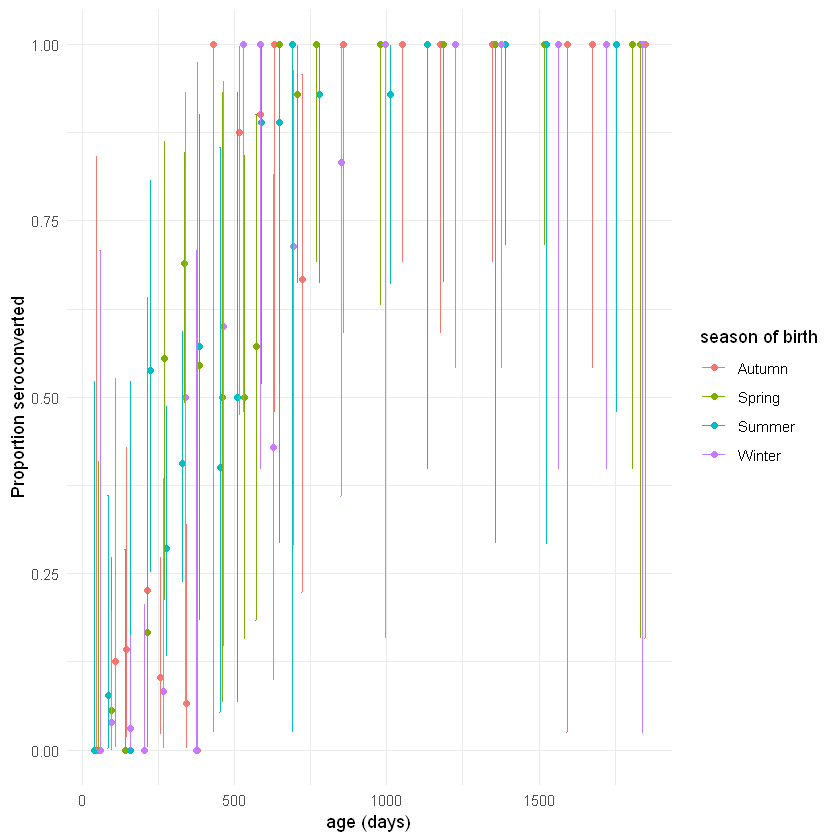

In [50]:
# Plot the whole data frame (difficult to read)
ggplot(data) +
  geom_point(aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = season_birth)) +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(colour = "season of birth")

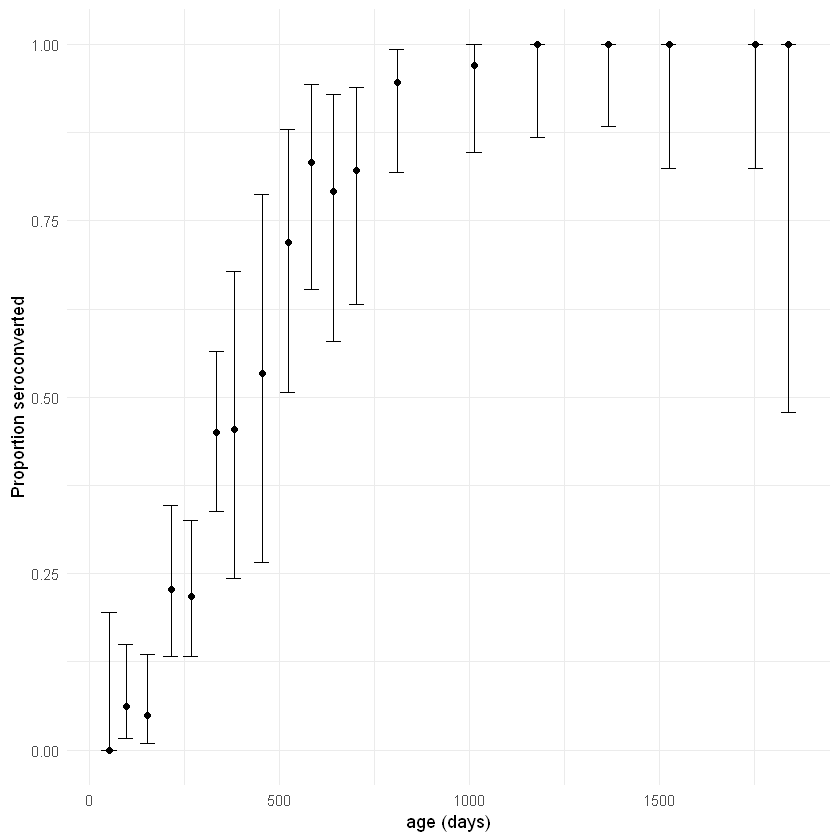

In [51]:
ggplot(data_no_season) +
  geom_point(aes(x=agemid, y=seroprev_mean)) +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  ylab("Proportion seroconverted") + xlab("age (days)") 

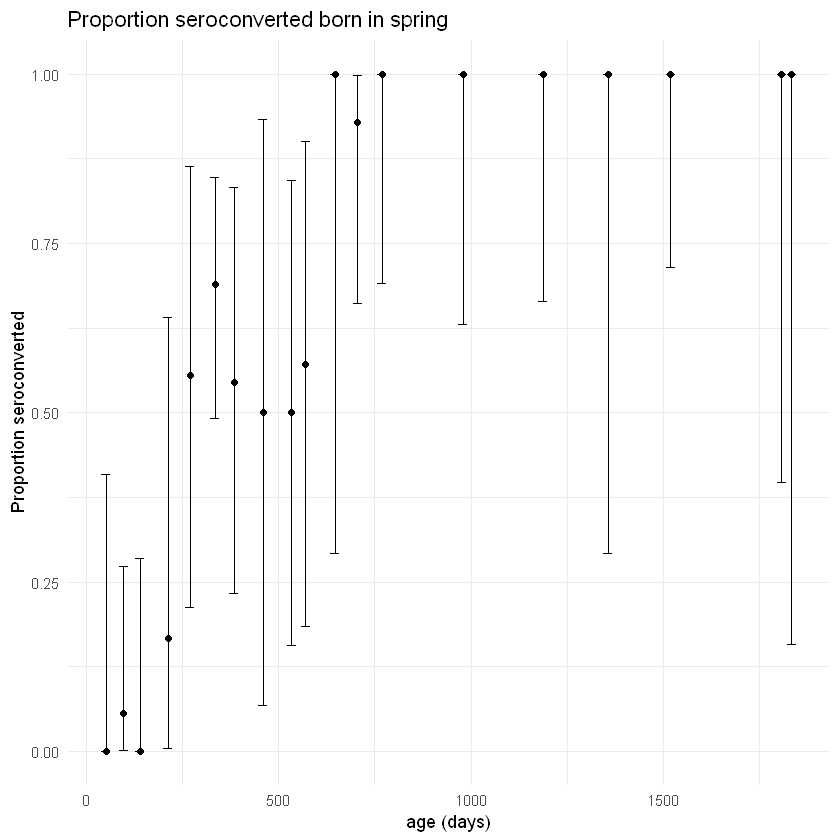

In [52]:
#Plot by season
spring.df <- subset(data, season_birth == 'Spring')
ggplot(spring.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in spring")

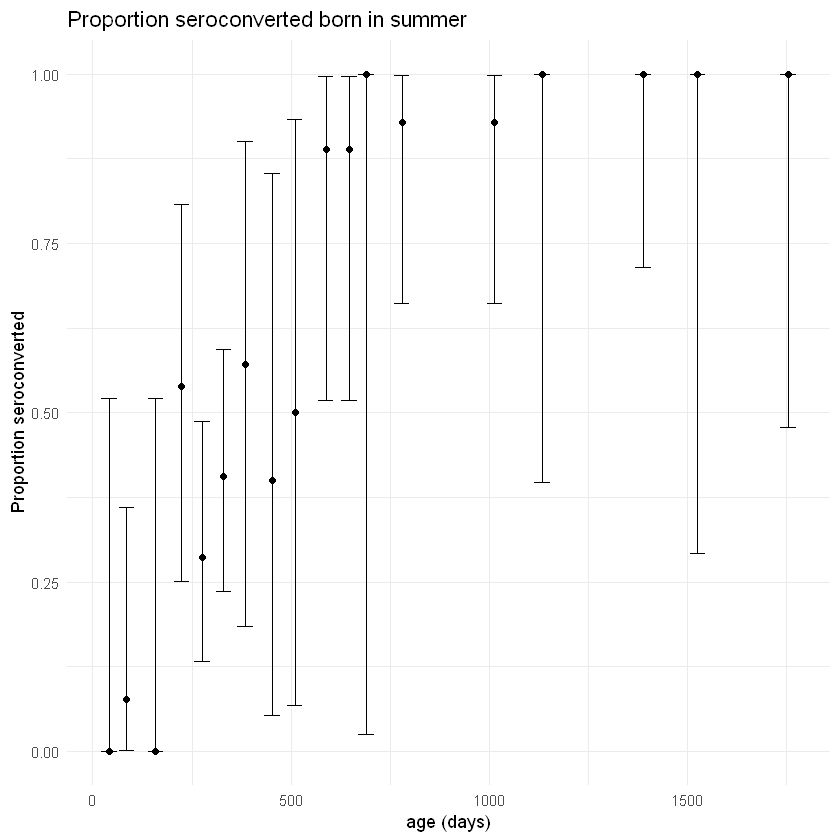

In [53]:
summer.df <- subset(data, season_birth == 'Summer')
ggplot(summer.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in summer")


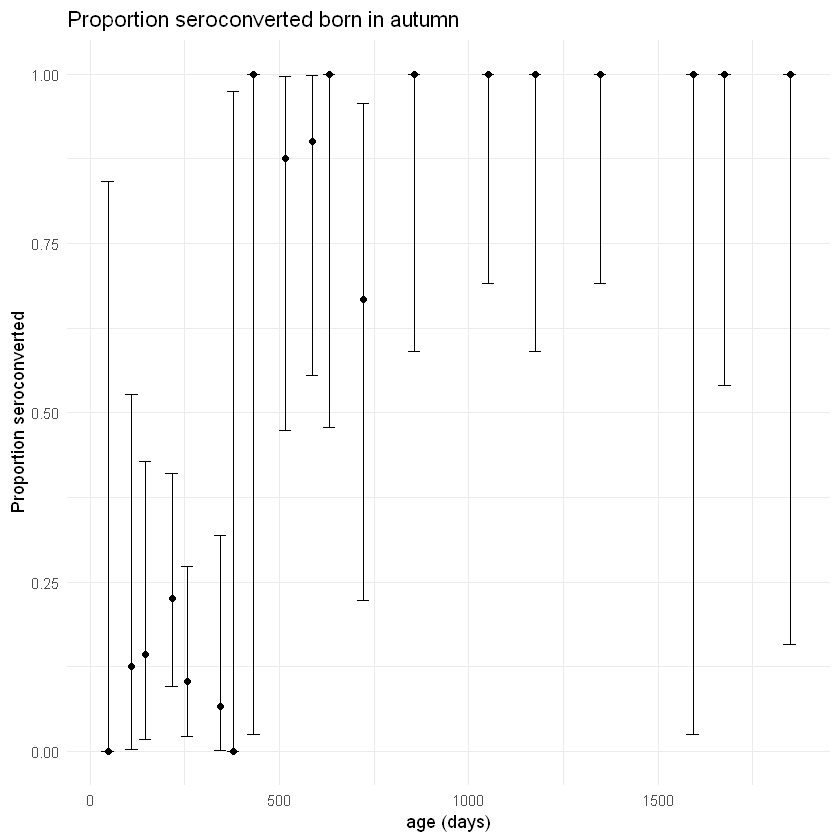

In [54]:
autumn.df <- subset(data, season_birth == 'Autumn')
ggplot(autumn.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in autumn")

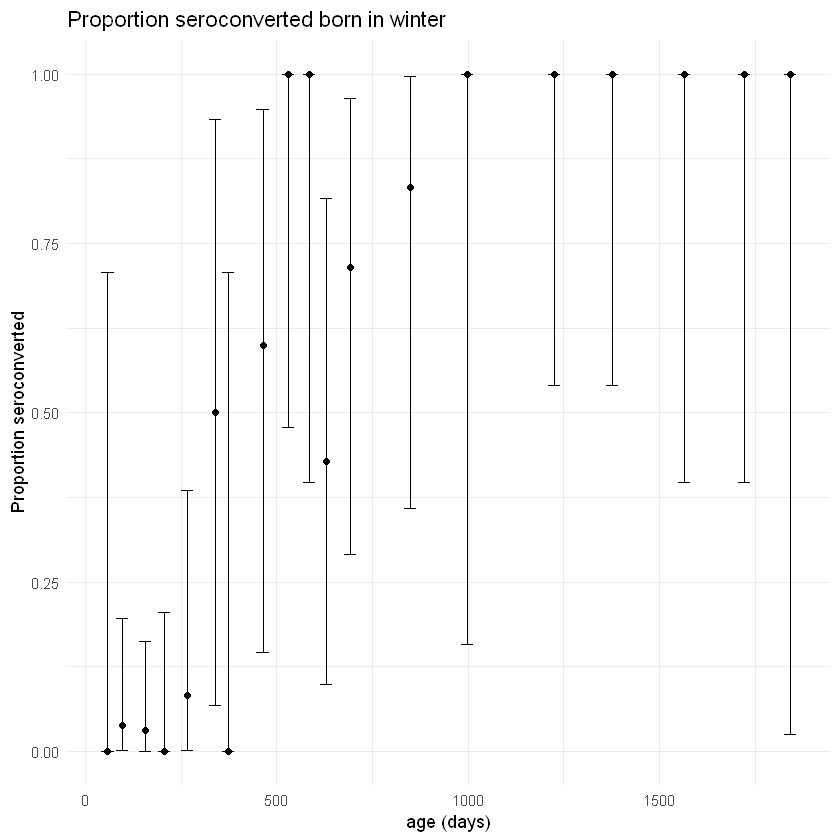

In [55]:
winter.df <- subset(data, season_birth == 'Winter')
ggplot(winter.df) +
  geom_point(aes(x=agemid, y=seroprev_mean), color = 'black') +
  geom_errorbar(aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95),colour ='black') +
  ylab("Proportion seroconverted") + xlab("age (days)") + labs(title ="Proportion seroconverted born in winter")

In [56]:
# Notes:
# - The states are integrated on a log-scale to avoid negative states, which is why we log-transform them when in the model input and exponentiate them inside the model
#- There is one model for each season of birth

# Children born in spring
model_sp <- function(theta, age, inits) {
  
  #Children born in spring
  catalytic <- function(age, state, param) {
    
    # FOI / seroconversion rate
    spring_FOI = 0
    summer_FOI = 0
    autumn_FOI = 0
    winter_FOI = 0
    
    if ( (age<= 30.41*3)                                      #experience the spring FOI during spring
        || ( (age>=365) & (age <=(365+30.41*3)) ) 
        || ( (age >= 2*365) & (age <= (2*365+30.41*3))) 
        || ((age >= 3*365) & (age <= (3*365+30.41*3))) 
        || ((age >= 4*365) & (age <= (4*365+30.41*3))) 
        || ((age >= 5*365) & (age <= (5*365+30.41*3))) ){
      spring_FOI = 1
    } 
    
    if ( (age>30.41*3 & age <=30.41*6 )                       #experience the summer FOI during summer
         || ( (age>365+30.41*3) & (age <=(365+30.41*6)) ) 
         || ( (age > 2*365 + 30.41*3) & (age <= (2*365+30.41*6))) 
         || ((age > 3*365 + 30.41*3) & (age <= (3*365+30.41*6))) 
         || ((age > 4*365 + 30.41*3) & (age <= (4*365+30.41*6))) 
         || ((age > 5*365 + 30.41*3) & (age <= (5*365+30.41*6))) ){
      summer_FOI = 1
    } 
    
    if ( (age>30.41*6 & age <=30.41*9 )                     # experience the autumn FOI during autumn
         || ( (age>365+30.41*6) & (age <=(365+30.41*9)) ) 
         || ( (age > 2*365 + 30.41*6) & (age <= (2*365+30.41*9))) 
         || ((age > 3*365 + 30.41*6) & (age <= (3*365+30.41*9))) 
         || ((age > 4*365 + 30.41*6) & (age <= (4*365+30.41*9))) 
         || ((age > 5*365 + 30.41*6) & (age <= (5*365+30.41*9))) ){
      autumn_FOI = 1
    } 
    
    if ( (age>30.41*9 & age <=30.41*12 )                     #experience the winter FOI during winter
         || ( (age>365+30.41*9) & (age <=(365+30.41*12)) ) 
         || ( (age > 2*365 + 30.41*9) & (age <= (2*365+30.41*12))) 
         || ((age > 3*365 + 30.41*9) & (age <= (3*365+30.41*12))) 
         || ((age > 4*365 + 30.41*9) & (age <= (4*365+30.41*12))) 
         || ((age > 5*365 + 30.41*9) & (age <= (5*365+30.41*12))) ){
      winter_FOI = 1
    } 
    
    lambda = param[["P"]]*spring_FOI + param[["M"]]*summer_FOI + param[["A"]]*autumn_FOI + param[["W"]]*winter_FOI #FOI depends on the season
    mu = param[["B"]] 
    
    # states 
    # proportion with maternal immunity
    M = exp(state[1]) # born in spring
    # Susceptible
    S = exp(state[2]) # susceptible born in spring
    #Seroconverted
    Z = exp(state[3]) # seroconverted after infection born in spring
    
    # changes in states
    dM = - mu*M
    dS = + mu *M  - lambda *S  
    dZ  = + lambda *S 
   
    return(list(c(dM /M ,
                  dS /S , 
                  dZ /Z ), 
                lambda =lambda ,
                mu =mu ))
    
    
  }
  
traj <- data.frame(ode(y=c(M =log(inits[["M"]]),
                             S =log(inits[["S"]]),
                             Z =log(inits[["Z"]])),
                         times=age, 
                         func=catalytic, 
                         parms=theta, 
                         method="lsoda",
                         verbose=F))
  

  
  traj$conv <- exp(traj$Z ) # cumulative seroconversion (=observed state)
  traj$inc <- c(inits[["Z"]], diff(exp(traj$Z ))) # incident seroconversion
  
  return(traj)
  
}

model_sm <- function(theta, age, inits) {
  
  catalytic <- function(age, state, param) {
    
    spring_FOI = 0
    summer_FOI = 0
    autumn_FOI = 0
    winter_FOI = 0
    
    if ( (age<= 30.41*3)                                      #experience the summer FOI during summer
         || ( (age>=365) & (age <=(365+30.41*3)) ) 
         || ( (age >= 2*365) & (age <= (2*365+30.41*3))) 
         || ((age >= 3*365) & (age <= (3*365+30.41*3))) 
         || ((age >= 4*365) & (age <= (4*365+30.41*3))) 
         || ((age >= 5*365) & (age <= (5*365+30.41*3))) ){
      summer_FOI = 1
    } 
    
    if ( (age>30.41*3 & age <=30.41*6 )                       #experience the autumn FOI during autumn
         || ( (age>365+30.41*3) & (age <=(365+30.41*6)) ) 
         || ( (age > 2*365 + 30.41*3) & (age <= (2*365+30.41*6))) 
         || ((age > 3*365 + 30.41*3) & (age <= (3*365+30.41*6))) 
         || ((age > 4*365 + 30.41*3) & (age <= (4*365+30.41*6))) 
         || ((age > 5*365 + 30.41*3) & (age <= (5*365+30.41*6))) ){
      autumn_FOI = 1
    } 
    
    if ( (age>30.41*6 & age <=30.41*9 )                     # experience the winter FOI during winter
         || ( (age>365+30.41*6) & (age <=(365+30.41*9)) ) 
         || ( (age > 2*365 + 30.41*6) & (age <= (2*365+30.41*9))) 
         || ((age > 3*365 + 30.41*6) & (age <= (3*365+30.41*9))) 
         || ((age > 4*365 + 30.41*6) & (age <= (4*365+30.41*9))) 
         || ((age > 5*365 + 30.41*6) & (age <= (5*365+30.41*9))) ){
      winter_FOI = 1
    } 
    
    if ( (age>30.41*9 & age <=30.41*12 )                     #experience the spring FOI during spring
         || ( (age>365+30.41*9) & (age <=(365+30.41*12)) ) 
         || ( (age > 2*365 + 30.41*9) & (age <= (2*365+30.41*12))) 
         || ((age > 3*365 + 30.41*9) & (age <= (3*365+30.41*12))) 
         || ((age > 4*365 + 30.41*9) & (age <= (4*365+30.41*12))) 
         || ((age > 5*365 + 30.41*9) & (age <= (5*365+30.41*12))) ){
      spring_FOI = 1
    } 
    
    lambda   = param[["P"]]*spring_FOI + param[["M"]]*summer_FOI + param[["A"]]*autumn_FOI + param[["W"]]*winter_FOI
    # waning maternal immunity, same for all children
    mu   = param[["B"]] 
    
    # states 
    M   = exp(state[1]) # born in summer
    S   = exp(state[2]) # susceptible born in summer
    Z   = exp(state[3]) # seroconverted after infection born in summer
    
    # changes in states
    dM   = -mu  *M  
    dS   = + mu  *M   - lambda  *S   
    dZ   = + lambda  *S   
    
    return(list(c(dM  /M  ,dS  /S  ,dZ  /Z  ), lambda   = lambda  ,
                mu  =mu  ))
    
    
  }
  
  traj <- data.frame(ode(y=c(M  =log(inits[["M"]]),
                             S  =log(inits[["S"]]),
                             Z  =log(inits[["Z"]])),
                         times=age, 
                         func=catalytic, 
                         parms=theta, 
                         method="lsoda",
                         verbose=F))
  
  
  
  traj$conv <- exp(traj$Z  ) # cumulative seroconversion (=observed state)
  traj$inc <- c(inits[["Z"]], diff(exp(traj$Z  ))) # incident seroconversion
  
  return(traj)
  
}

model_au <- function(theta, age, inits) {
  
  catalytic <- function(age, state, param) {
    
    spring_FOI = 0
    summer_FOI = 0
    autumn_FOI = 0
    winter_FOI = 0
    
    if ( (age<= 30.41*3)                                      #experience the autumn FOI during autumn
         || ( (age>=365) & (age <=(365+30.41*3)) ) 
         || ( (age >= 2*365) & (age <= (2*365+30.41*3))) 
         || ((age >= 3*365) & (age <= (3*365+30.41*3))) 
         || ((age >= 4*365) & (age <= (4*365+30.41*3))) 
         || ((age >= 5*365) & (age <= (5*365+30.41*3))) ){
      autumn_FOI = 1
    } 
    
    if ( (age>30.41*3 & age <=30.41*6 )                       #experience the winter FOI during winter
         || ( (age>365+30.41*3) & (age <=(365+30.41*6)) ) 
         || ( (age > 2*365 + 30.41*3) & (age <= (2*365+30.41*6))) 
         || ((age > 3*365 + 30.41*3) & (age <= (3*365+30.41*6))) 
         || ((age > 4*365 + 30.41*3) & (age <= (4*365+30.41*6))) 
         || ((age > 5*365 + 30.41*3) & (age <= (5*365+30.41*6))) ){
      winter_FOI = 1
    } 
    
    if ( (age>30.41*6 & age <=30.41*9 )                     # experience the spring FOI during spring
         || ( (age>365+30.41*6) & (age <=(365+30.41*9)) ) 
         || ( (age > 2*365 + 30.41*6) & (age <= (2*365+30.41*9))) 
         || ((age > 3*365 + 30.41*6) & (age <= (3*365+30.41*9))) 
         || ((age > 4*365 + 30.41*6) & (age <= (4*365+30.41*9))) 
         || ((age > 5*365 + 30.41*6) & (age <= (5*365+30.41*9))) ){
      spring_FOI = 1
    } 
    
    if ( (age>30.41*9 & age <=30.41*12 )                     #experience the summer FOI during summer
         || ( (age>365+30.41*9) & (age <=(365+30.41*12)) ) 
         || ( (age > 2*365 + 30.41*9) & (age <= (2*365+30.41*12))) 
         || ((age > 3*365 + 30.41*9) & (age <= (3*365+30.41*12))) 
         || ((age > 4*365 + 30.41*9) & (age <= (4*365+30.41*12))) 
         || ((age > 5*365 + 30.41*9) & (age <= (5*365+30.41*12))) ){
     summer_FOI = 1
    } 
    
    lambda   = param[["P"]]*spring_FOI + param[["M"]]*summer_FOI + param[["A"]]*autumn_FOI + param[["W"]]*winter_FOI
    
    # waning maternal immunity, same for all children
    mu   = param[["B"]] 
    
    # states 
    # proportion with maternal immunity
    M   = exp(state[1]) # born in autumn
    # Susceptible
    S   = exp(state[2]) #susceptible born in autumn
    #Seroconverted
    Z   = exp(state[3]) # seroconverted after infection born in autumn
    
    # changes in states
    dM   = -mu  *M  
    dS   = + mu  *M   - lambda  *S   
    dZ   = + lambda  *S  
    
    return(list(c(dM  /M  ,
                  dS  /S  , dZ  /Z  ), 
                lambda   = lambda  , 
                mu  =mu  ))
    
    
  }
  
  traj <- data.frame(ode(y=c(M  =log(inits[["M"]]),
                             S  =log(inits[["S"]]),
                             Z  =log(inits[["Z"]])),
                         times=age, 
                         func=catalytic, 
                         parms=theta, 
                         method="lsoda",
                         verbose=F))
  
  
  
  traj$conv <- exp(traj$Z  ) # cumulative seroconversion (=observed state)
  traj$inc <- c(inits[["Z"]], diff(exp(traj$Z  )))
  return(traj)
  
}

model_wt <- function(theta, age, inits) {
  
  catalytic <- function(age, state, param) {
    
    
    #FOI
    spring_FOI = 0
    summer_FOI = 0
    autumn_FOI = 0
    winter_FOI = 0
    
    if ( (age<= 30.41*3)                                      #experience the winter FOI during winter
         || ( (age>=365) & (age <=(365+30.41*3)) ) 
         || ( (age >= 2*365) & (age <= (2*365+30.41*3))) 
         || ((age >= 3*365) & (age <= (3*365+30.41*3))) 
         || ((age >= 4*365) & (age <= (4*365+30.41*3))) 
         || ((age >= 5*365) & (age <= (5*365+30.41*3))) ){
      winter_FOI = 1
    } 
    
    if ( (age>30.41*3 & age <=30.41*6 )                       #experience the spring FOI during spring
         || ( (age>365+30.41*3) & (age <=(365+30.41*6)) ) 
         || ( (age > 2*365 + 30.41*3) & (age <= (2*365+30.41*6))) 
         || ((age > 3*365 + 30.41*3) & (age <= (3*365+30.41*6))) 
         || ((age > 4*365 + 30.41*3) & (age <= (4*365+30.41*6))) 
         || ((age > 5*365 + 30.41*3) & (age <= (5*365+30.41*6))) ){
      spring_FOI = 1
    } 
    
    if ( (age>30.41*6 & age <=30.41*9 )                     # experience the summer FOI during summer
         || ( (age>365+30.41*6) & (age <=(365+30.41*9)) ) 
         || ( (age > 2*365 + 30.41*6) & (age <= (2*365+30.41*9))) 
         || ((age > 3*365 + 30.41*6) & (age <= (3*365+30.41*9))) 
         || ((age > 4*365 + 30.41*6) & (age <= (4*365+30.41*9))) 
         || ((age > 5*365 + 30.41*6) & (age <= (5*365+30.41*9))) ){
      summer_FOI = 1
    } 
    
    if ( (age>30.41*9 & age <=30.41*12 )                     #experience the autumn FOI during autumn
         || ( (age>365+30.41*9) & (age <=(365+30.41*12)) ) 
         || ( (age > 2*365 + 30.41*9) & (age <= (2*365+30.41*12))) 
         || ((age > 3*365 + 30.41*9) & (age <= (3*365+30.41*12))) 
         || ((age > 4*365 + 30.41*9) & (age <= (4*365+30.41*12))) 
         || ((age > 5*365 + 30.41*9) & (age <= (5*365+30.41*12))) ){
      autumn_FOI = 1
    } 
    
    lambda   = param[["P"]]*spring_FOI + param[["M"]]*summer_FOI + param[["A"]]*autumn_FOI + param[["W"]]*winter_FOI
    # waning maternal immunity, same for all children
    mu   = param[["B"]] 
    
    # states 
    # proportion with maternal immunity
    M   = exp(state[1]) # born in winter
    # Susceptible
    S   = exp(state[2]) #susceptible born in winter
    #Seroconverted
    Z   = exp(state[3]) # seroconverted after infection born in winter
    
    # changes in states
    dM   = -mu  *M  
    dS   = + mu  *M   - lambda  *S  
    dZ   = + lambda  *S  
    
    return(list(c(dM  /M  ,
                 dS  /S  , 
                  dZ  /Z  ), 
                 lambda   = lambda  ,
                mu  =mu  ))
    
    
  }
  
  traj <- data.frame(ode(y=c(M  =log(inits[["M"]]),
                             S  =log(inits[["S"]]),
                             Z  =log(inits[["Z"]])),
                         times=age, 
                         func=catalytic, 
                         parms=theta, 
                         method="lsoda",
                         verbose=F))
  
  
  
  traj$conv <- exp(traj$Z  ) # cumulative seroconversion (=observed state)
  traj$inc <- c(inits[["Z"]], diff(exp(traj$Z  ))) # incident seroconversion
  
  return(traj)
  
}

#bring all models together
model_all <- function(theta, data, inits){
  traj <- data.frame(matrix(ncol = 8, nrow=0))
  colnames(traj) <- c('time', 'M', 'S', 'Z', 'lambda', 'mu', 'conv', 'inc')
  
  spring.df <- subset(data, season_birth == 'Spring')
  age_sp <- spring.df$agemid
  traj_sp <- model_sp(theta, age_sp, inits)
  traj <- rbind(traj, traj_sp)

  summer.df <- subset(data, season_birth == 'Summer')
  age_sm <- summer.df$agemid
  traj_sm <- model_sm(theta, age_sm, inits)
  traj <- rbind(traj, traj_sm)

  autumn.df <- subset(data, season_birth == 'Autumn')
  age_au <- autumn.df$agemid
  traj_au <- model_au(theta, age_au, inits)
  traj <- rbind(traj, traj_au)

  winter.df <- subset(data, season_birth == 'Winter')
  age_wt <- winter.df$agemid
  traj_wt <- model_wt(theta, age_wt, inits)
  traj <- rbind(traj, traj_wt)
  
  result = list(traj,traj_sp, traj_sm, traj_au, traj_wt)
  
  return (result)
}

In [57]:
# MODEL EQUATION  ------------------------------------------------------------
# TRAJECTORY SIMULATION  ------------------------------------------------------------

# This function draws n samples from the posterior to calculate the posterior predictive uncertainty (95%)

maketrajsim <- function(trace, theta, age, model, inits, ndraw) {
  
  #Draw n fitted parameter vectors theta from the MCMC object
  sample <- getSample(trace, parametersOnly = TRUE, thin=1, numSamples=ndraw) #trace is a sampler, parametersOnly = T means that likelihood, posterior and prior values are not provided in the output, thin = thinning parameter
  
  traj.rep <- adply(.data=sample, .margins=1, .progress="text", .parallel=F, .fun=function(x) { #split sample by 1 = rows and apply function
    
    #Define the theta as the estimated parameters from the current draw and the fixed parameters
    theta.sample <- c(x, theta[!is.na(theta)])
    
    #Simulate trajectory for selected theta
    traj <- match.fun(model)(theta.sample, age, inits) #match.fun extracts the underlying function
    traj <- cbind(as.data.frame(t(x)), traj)
  })
  
  colnames(traj.rep)[1] <- "replicate"
  return(traj.rep)
  
}

maketrajsim2 <- function(trace, theta, age, model, data, inits, ndraw, season) {
  
  #Draw n fitted parameter vectors theta from the MCMC object
  sample <- getSample(trace, parametersOnly = TRUE, thin=1, numSamples=ndraw) #trace is a sampler, parametersOnly = T means that likelihood, posterior and prior values are not provided in the output, thin = thinning parameter
  
  traj.rep <- adply(.data=sample, .margins=1, .progress="text", .parallel=F, .fun=function(x) { #split sample by 1 = rows and apply function
    
    #Define the theta as the estimated parameters from the current draw and the fixed parameters
    theta.sample <- c(x, theta[!is.na(theta)])
    
    #Simulate trajectory for selected theta
    traj <- as.data.frame(match.fun(model)(theta.sample, data, inits)[season]) #match.fun extracts the underlying function
    traj <- cbind(as.data.frame(t(x)), traj)
  })
  
  colnames(traj.rep)[1] <- "replicate"
  return(traj.rep)
  
}


In [58]:
# THETA ---------------------------------------------------------

# P = mean FOI (proportion infected per day) for children born in Spring
# M = mean FOI for children born in summer
# A = mean FOI for children born in autumn
# W = mean FOI for children born in winter
# B = rate of waning maternal immunity
theta <- c(P = 0.00156, M = 0.00842, A=0.00233, W = 0.00298, B = 0.0201) # these are just random values, to be fitted

# INITS ---------------------------------------------------------
inits <- c(M=1-1e-12-1e-12, S=1e-12, Z=1e-12)

# SIMULATION TIME  ---------------------------------------------------------
data <- arrange(data, agemid)
agepred <- data$agemid
agepred_sp <- spring.df$agemid
agepred_sm <- summer.df$agemid
agepred_au <- autumn.df$agemid
agepred_wt <- winter.df$agemid

In [59]:
# TEST MODEL  --------------------------------------------------------
test_all <- as.data.frame(model_all (theta, data, inits)[1])
test_sp2 <- as.data.frame(model_all (theta, data, inits)[2])
test_sm2 <- as.data.frame(model_all (theta, data, inits)[3])
test_au2 <- as.data.frame(model_all (theta, data, inits)[4])
test_wt2 <- as.data.frame(model_all (theta, data, inits)[5])


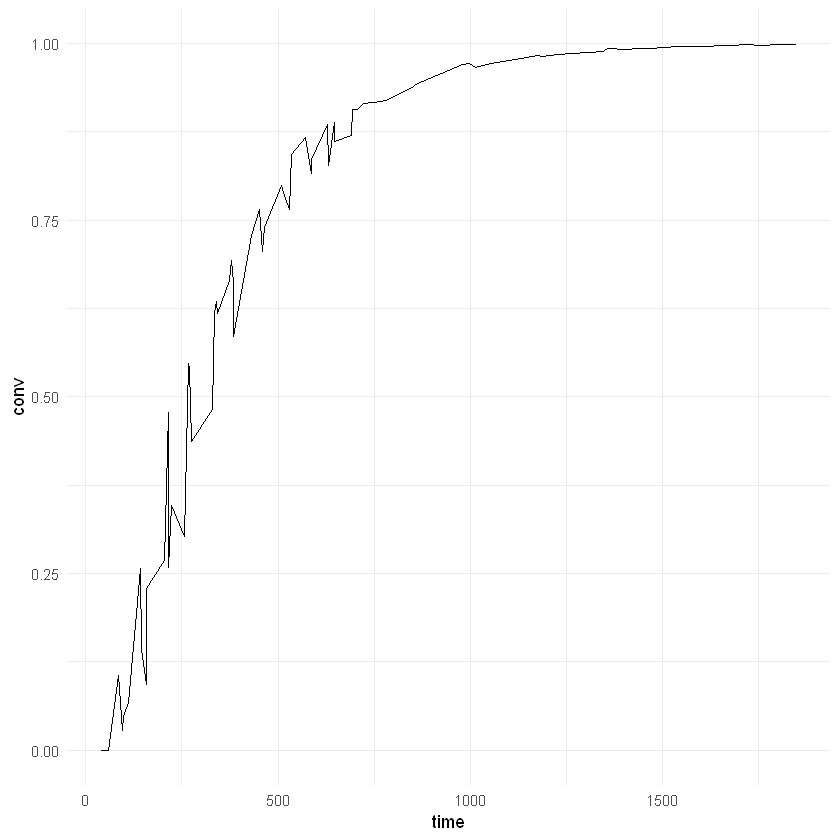

In [60]:
ggplot(test_all) + geom_line(aes(x=time, y=conv))

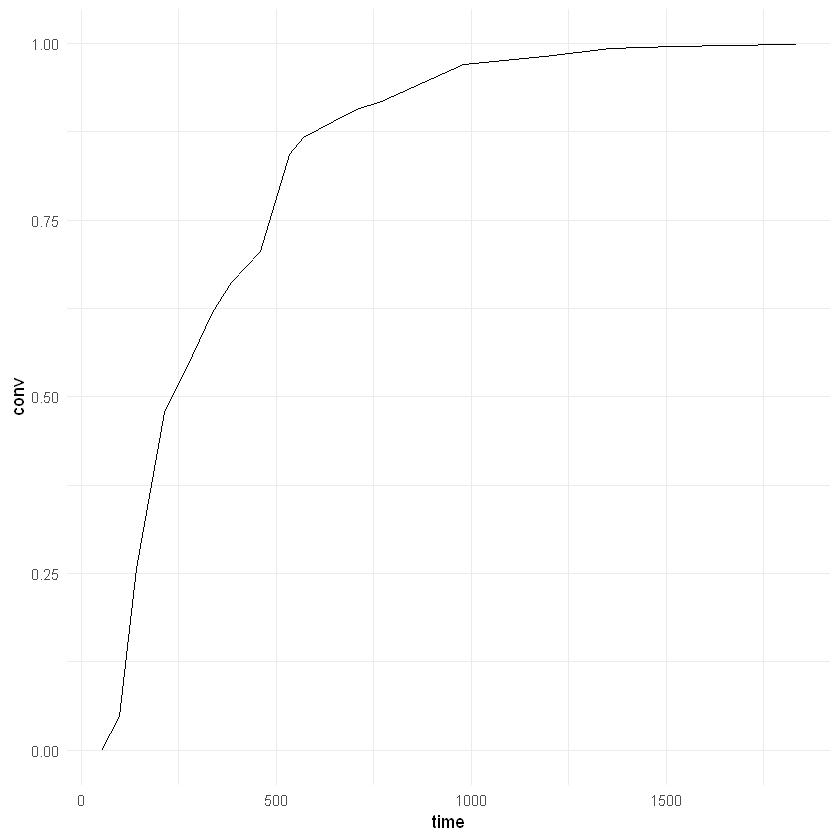

In [61]:
ggplot(test_sp2) + geom_line(aes(x=time, y=conv))

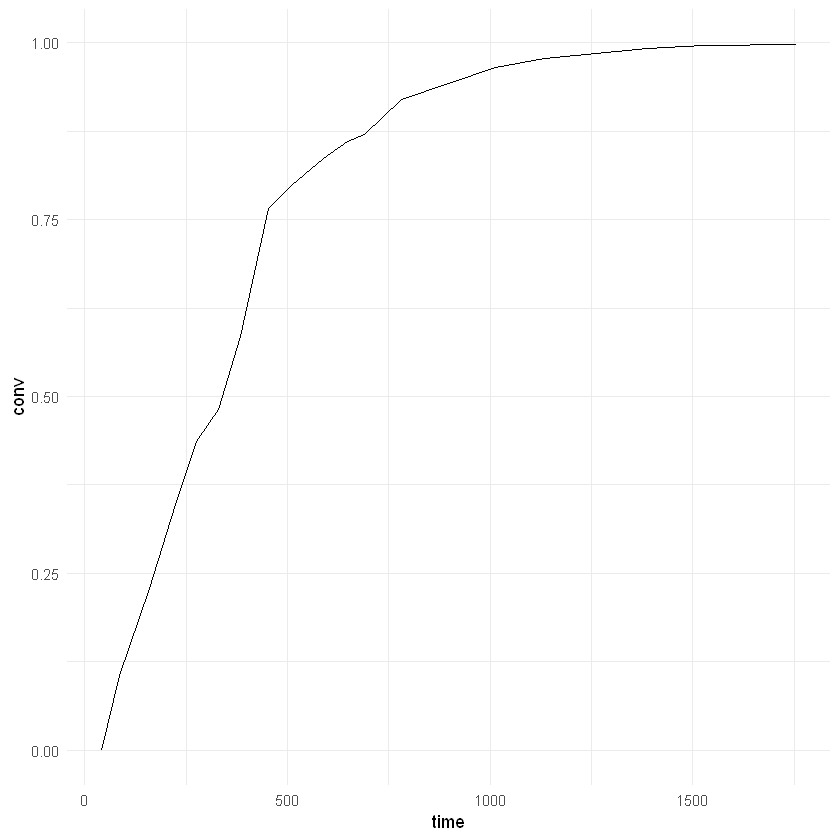

In [62]:
ggplot(test_sm2) + geom_line(aes(x=time, y=conv))

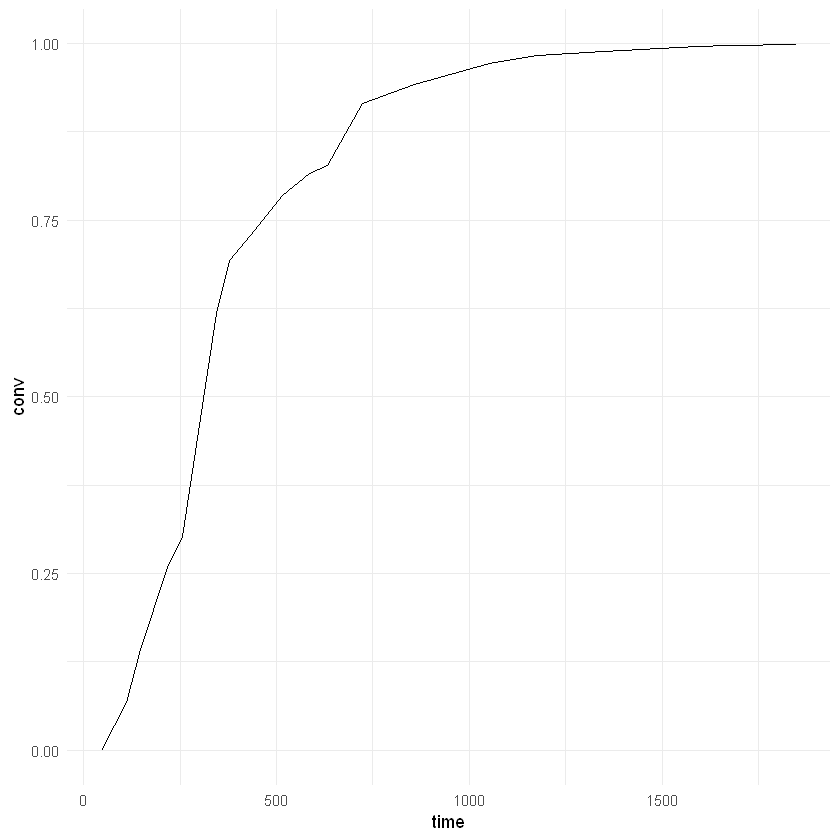

In [63]:
ggplot(test_au2) + geom_line(aes(x=time, y=conv))

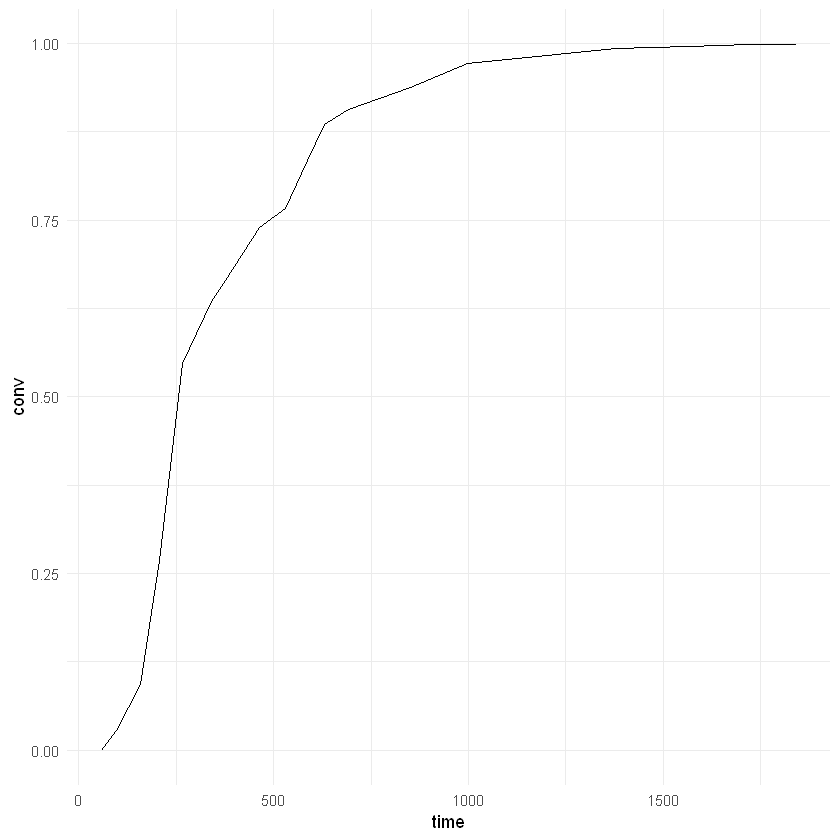

In [64]:
ggplot(test_wt2) + geom_line(aes(x=time, y=conv))

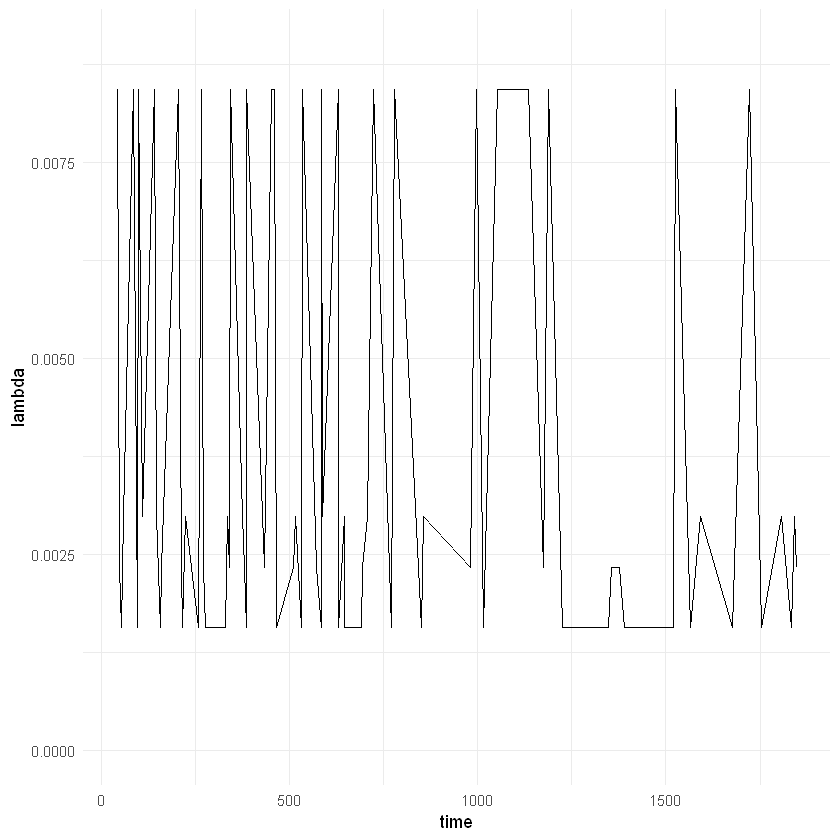

In [65]:
ggplot(test_all) + geom_line(aes(x=time, y=lambda)) + ylim(0,0.009)

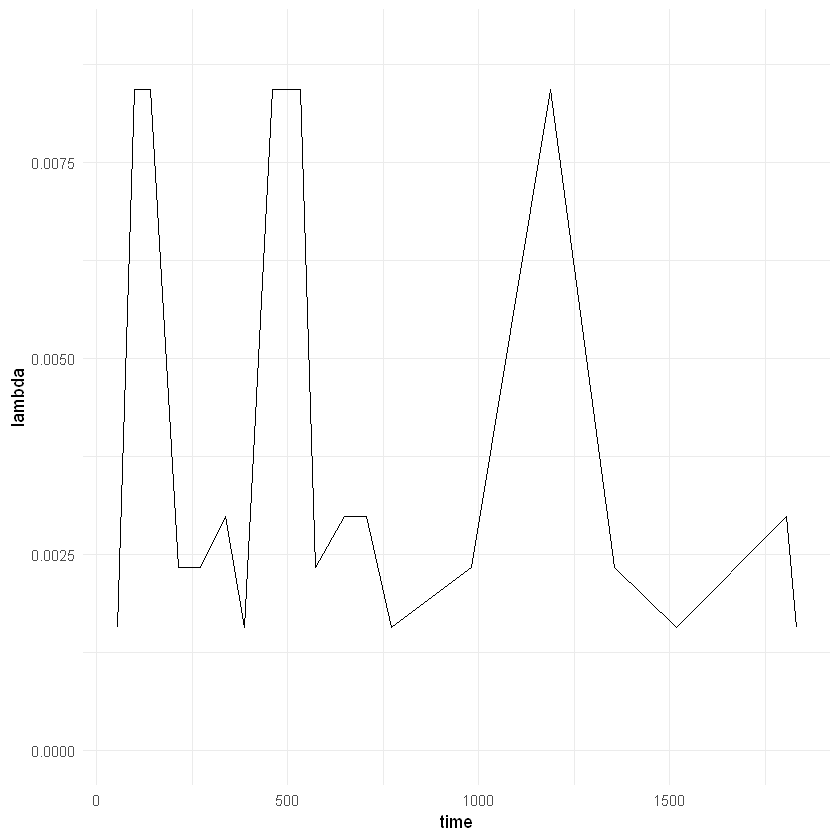

In [66]:
ggplot(test_sp2) + geom_line(aes(x=time, y=lambda))+ylim(0,0.009) #should vary

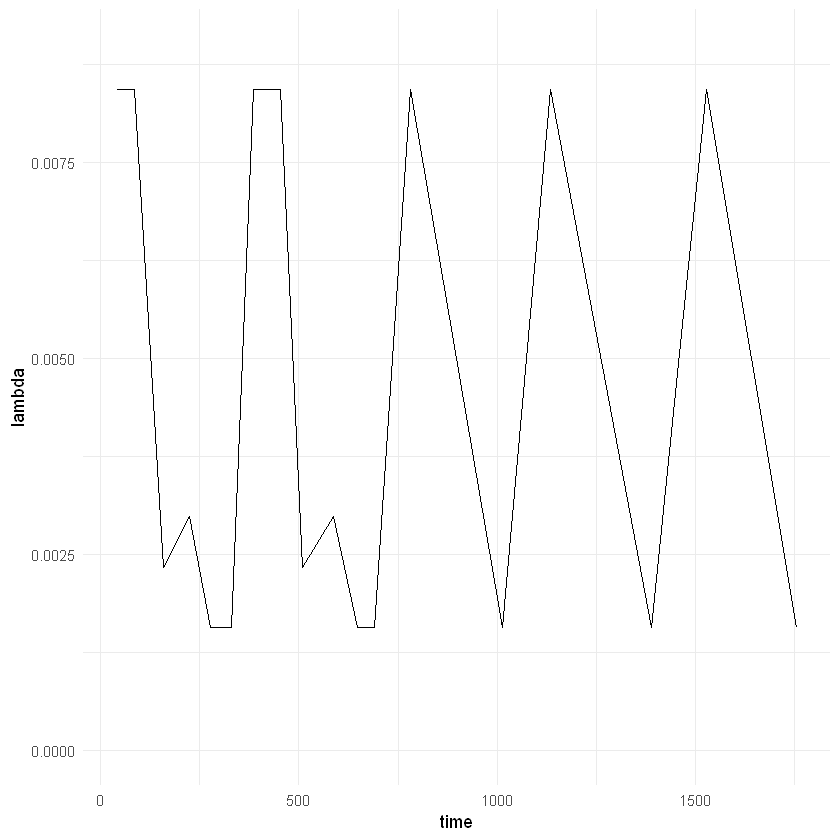

In [67]:
ggplot(test_sm2) + geom_line(aes(x=time, y=lambda))+ylim(0,0.009) #should vary

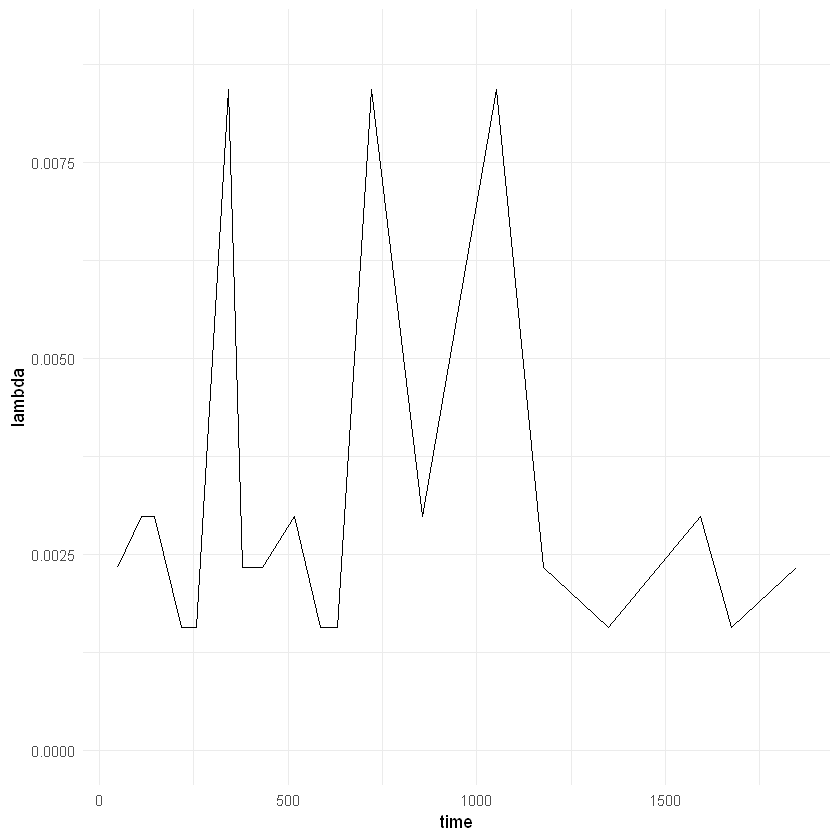

In [70]:
ggplot(test_au2) + geom_line(aes(x=time, y=lambda))+ ylim(0,0.009)#should vary

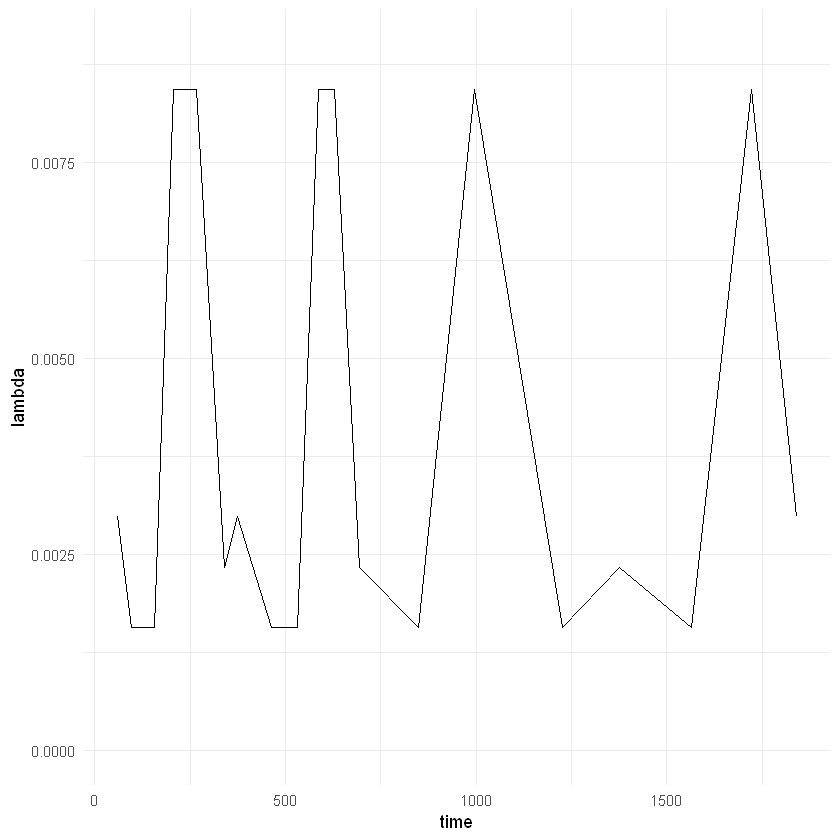

In [69]:
ggplot(test_wt2) + geom_line(aes(x=time, y=lambda))+ylim(0,0.009) #should vary

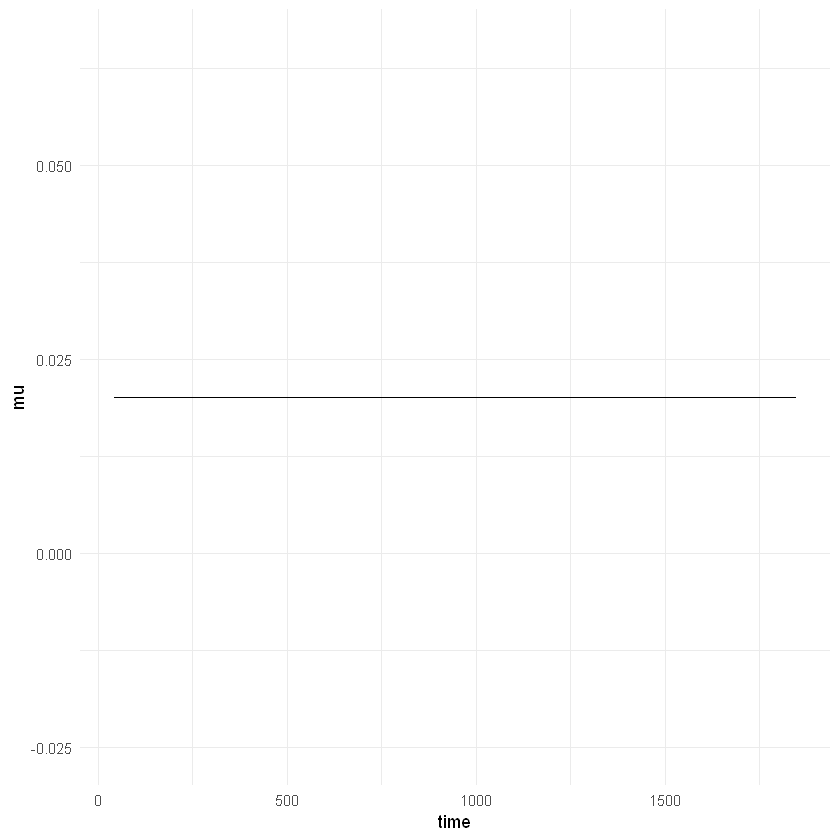

In [24]:
ggplot(test_all) + geom_line(aes(x=time, y=mu))

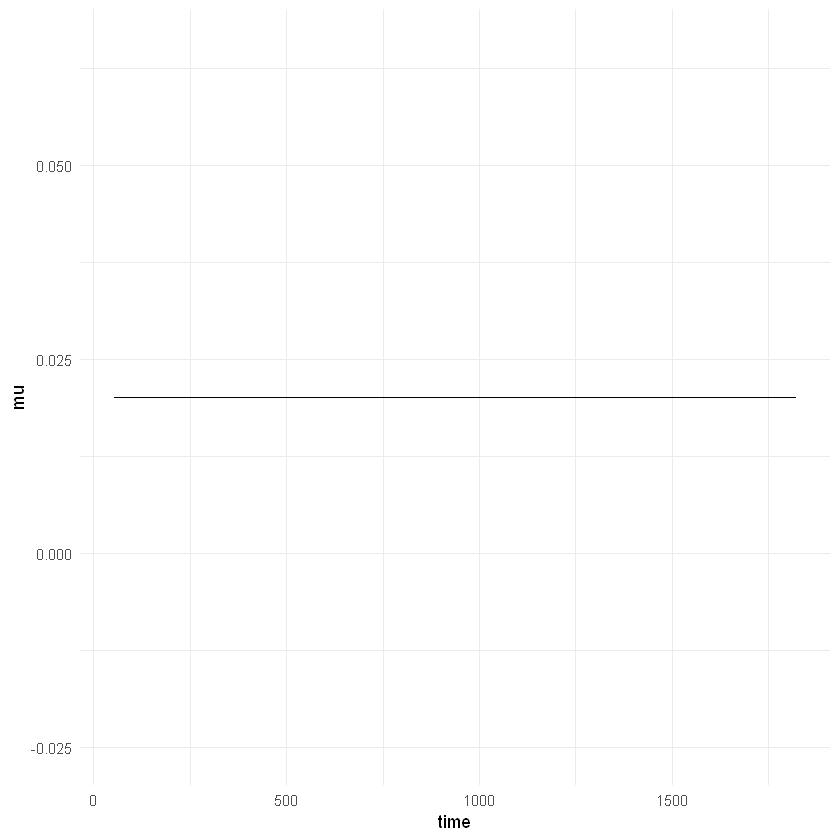

In [25]:
ggplot(test_sp2) + geom_line(aes(x=time, y=mu)) #should be constant

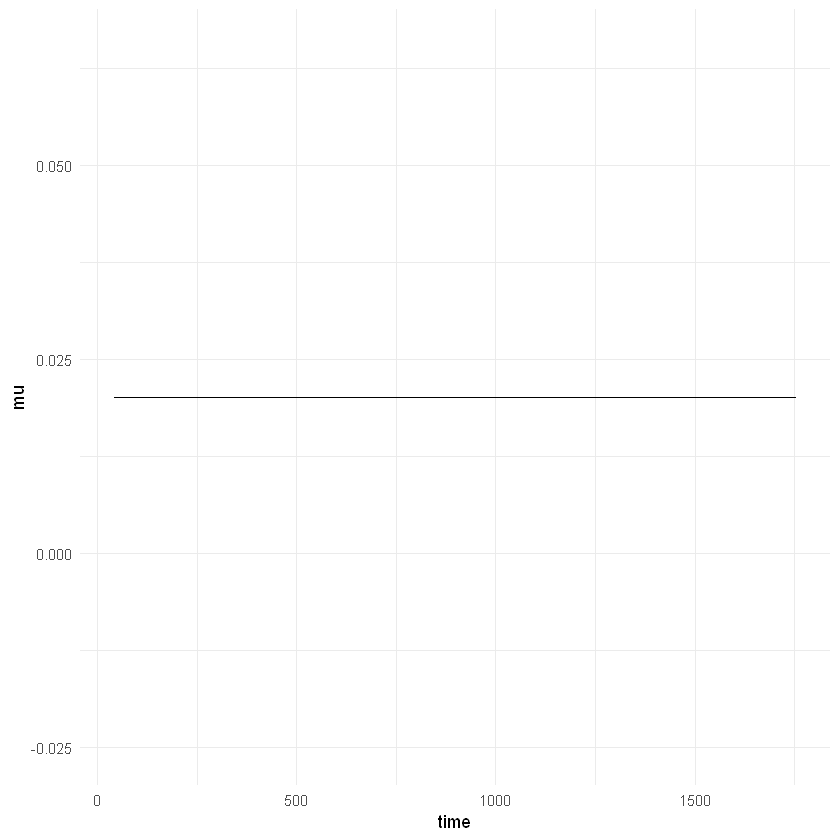

In [26]:
ggplot(test_sm2) + geom_line(aes(x=time, y=mu)) #should be constant

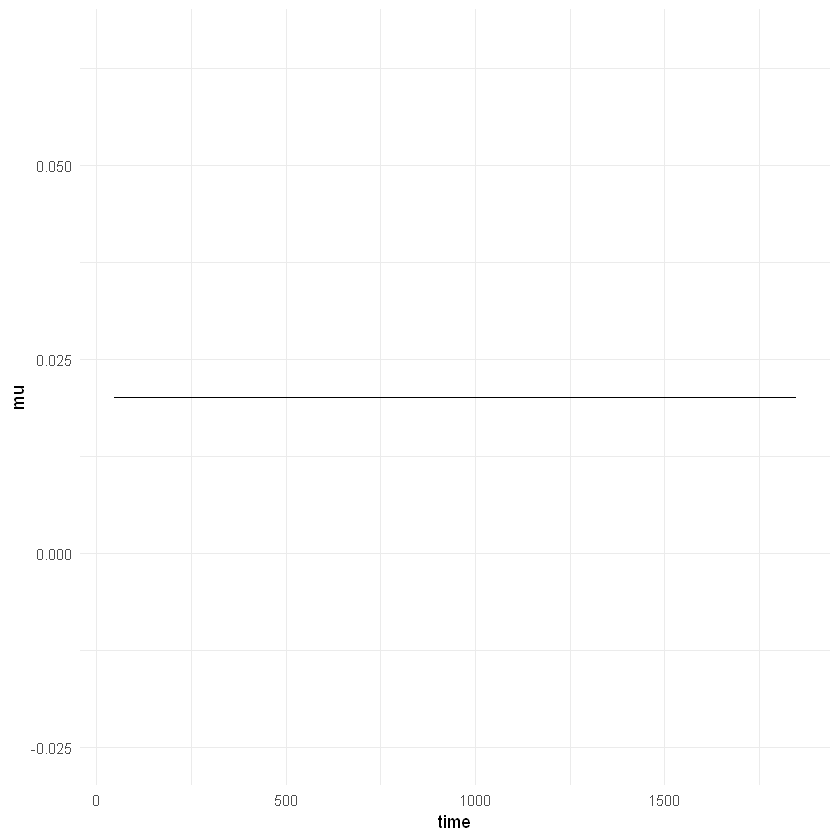

In [27]:
ggplot(test_au2) + geom_line(aes(x=time, y=mu)) #should be constant

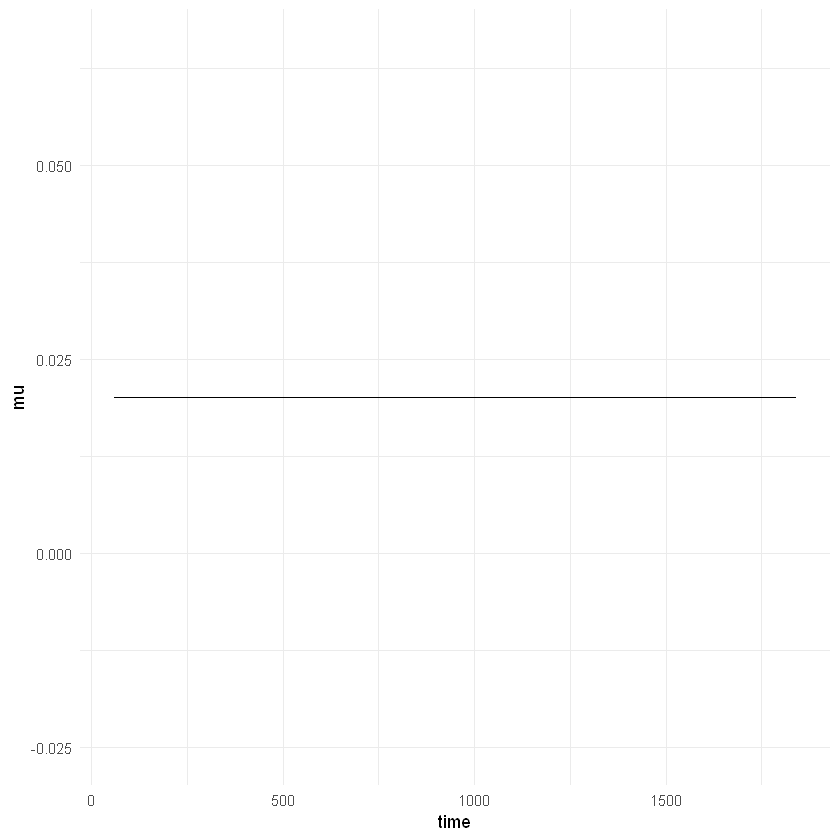

In [28]:
ggplot(test_wt2) + geom_line(aes(x=time, y=mu)) #should be constant

In [71]:
# LOG LIKELIHOOD FUNCTION ---------------------------------------------------------

# Log-likelihood for individual season models
loglik <- function(theta, age, data, model, inits) {
  
  traj <- match.fun(model)(theta, age, inits)
  
  nconv <- data$nconv[!is.na(data$nconv)] # n seroconverted at each age point  (data)
  N <- data$N[!is.na(data$nconv)] # total N at each age point  (data) 
  prob <- traj$conv[traj$time %in% data$agemid] # proportion seroconverted at each age point (model output)
  
  ll <- sum(dbinom(x=nconv,
                   size=N,
                   prob=prob,
                   log=TRUE), na.rm=TRUE)
  
  return(ll)
  
} 

# Log-likelihood for the whole dataset
# Season should be 1 for the whole dataset
# Season = 2 --> spring, season = 3 --> summer, season = 4 --> autumn, season = 5 --> winter
loglik2 <- function(theta, data, model, season, inits) {
  
  traj <- as.data.frame(match.fun(model)(theta, data, inits)[season])
  if (season == 2){
    data <- subset(data, season_birth == 'Spring')
  }else if (season == 3){
    data <- subset(data, season_birth == 'Summer')
  }else if (season == 4){
    data <- subset(data, season_birth == 'Autumn')
  }else if (season == 5){
    data <- subset(data, season_birth == 'Winter')
  }
  
  nconv <- data$nconv[!is.na(data$nconv)] # n seroconverted at each age point  (data)
  N <- data$N[!is.na(data$nconv)] # total N at each age point  (data) 
  prob <- traj$conv[traj$time %in% data$agemid] # proportion seroconverted at each age point (model output)
  
  ll <- sum(dbinom(x=nconv,
                   size=N,
                   prob=prob,
                   log=TRUE), na.rm=TRUE)
  
  return(ll)
  
} 


In [72]:
#Test likelihood function for each season
loglik2(theta, data, model_all, 1, inits)

[1] -1327.988

In [73]:
loglik(theta, agepred_sp, spring.df, model_sp, inits) # spring
loglik2(theta, data, model_all, 2, inits)

[1] -22.66078

[1] -22.66078

In [74]:
loglik(theta, agepred_sm, summer.df, model_sm, inits) # summer
loglik2(theta, data, model_all, 3, inits)

[1] -20.50005

[1] -20.50005

In [75]:
loglik(theta, agepred_au, autumn.df, model_au, inits) # autumn
loglik2(theta, data, model_all, 4, inits)

[1] -28.5515

[1] -28.5515

In [76]:
loglik(theta, agepred_wt, winter.df, model_wt, inits) # winter
loglik2(theta, data, model_all, 5, inits)

[1] -31.73419

[1] -31.73419

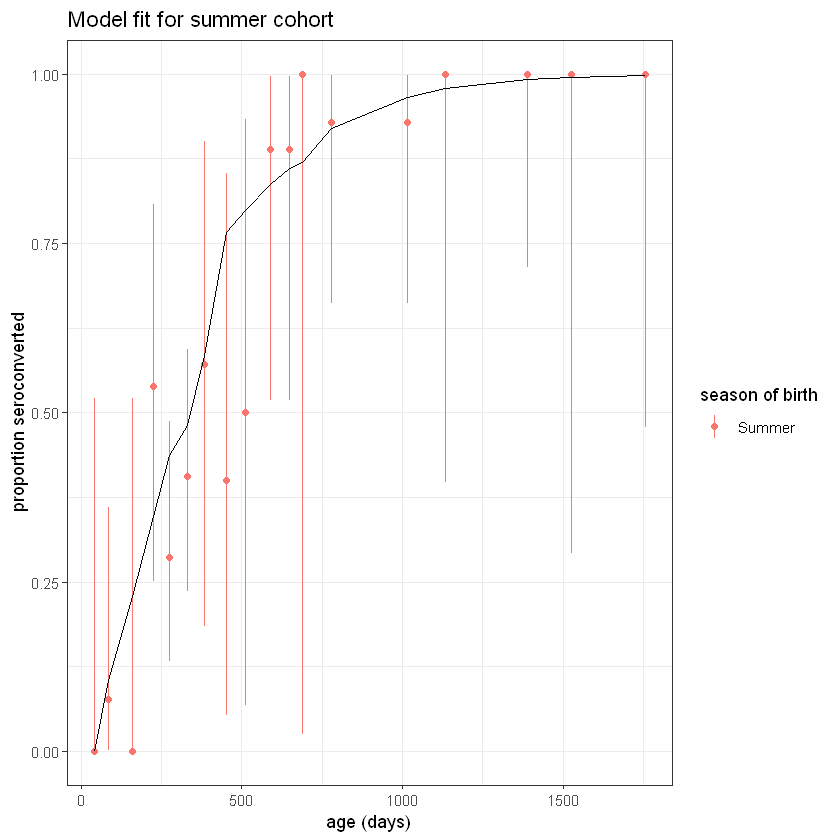

In [77]:
fit <- ggplot() + theme_bw() + ggtitle("Model fit for summer cohort") +
  geom_point(data=summer.df, aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_linerange(data=summer.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = season_birth)) +
  geom_line(data=test_sm2, aes(x=time, y=conv), color="black") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")

fit

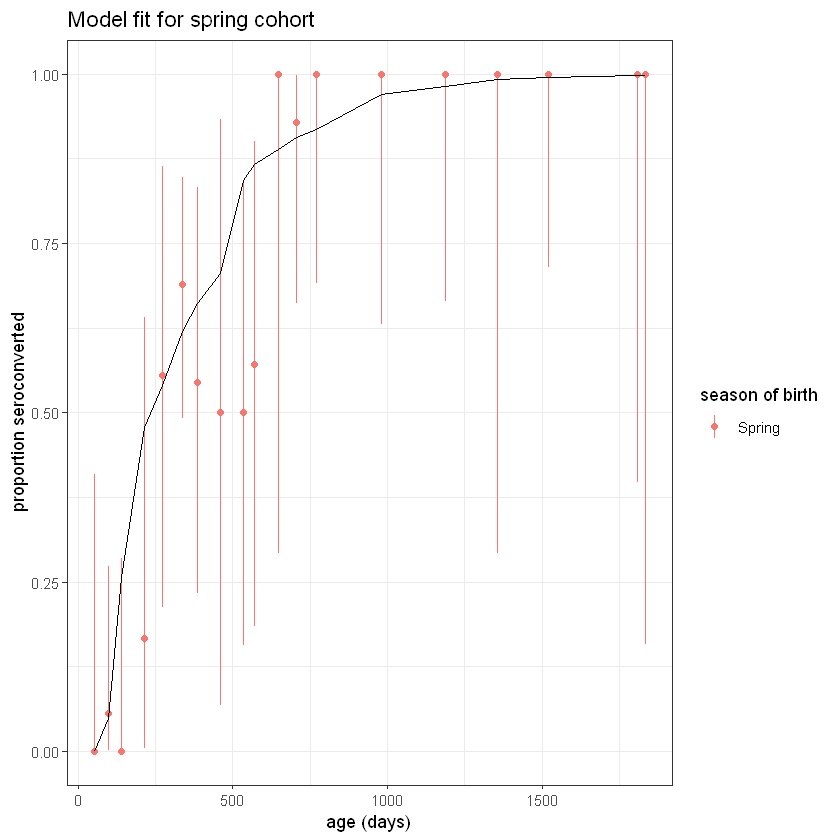

In [78]:
fit <- ggplot() + theme_bw() + ggtitle("Model fit for spring cohort") +
  geom_point(data=spring.df, aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_linerange(data=spring.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = season_birth)) +
  geom_line(data=test_sp2, aes(x=time, y=conv), color="black") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")

fit

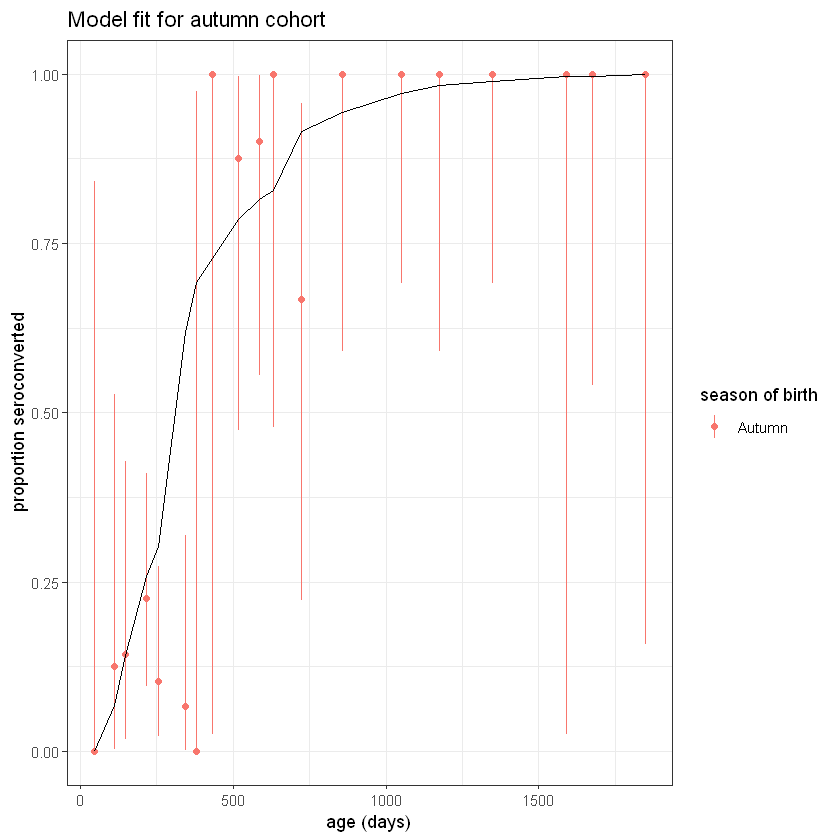

In [79]:
fit <- ggplot() + theme_bw() + ggtitle("Model fit for autumn cohort") +
  geom_point(data=autumn.df, aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_linerange(data=autumn.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = season_birth)) +
  geom_line(data=test_au2, aes(x=time, y=conv), color="black") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")

fit

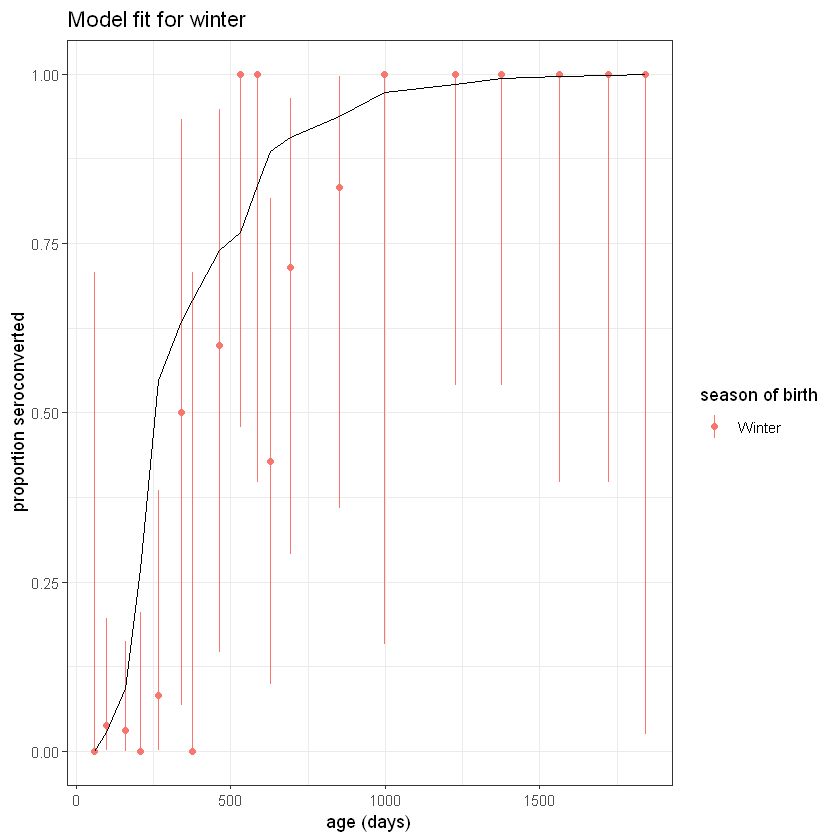

In [80]:
fit <- ggplot() + theme_bw() + ggtitle("Model fit for winter") +
  geom_point(data=winter.df, aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_linerange(data=winter.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95, colour = season_birth)) +
  geom_line(data=test_wt2, aes(x=time, y=conv), color="black") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")

fit

In [17]:
agemid <- c(47, 109, 146, 216, 256, 338, 364, 432, 513, 580, 629, 715, 786, 1052, 1176, 1348, 1592, 1676, 1848)
low95 <- c(1.0e-12, 6.9e-02, 9.16e-02, 1.21e-01, 1.34e-01, 1.65e-01, 1.71e-01, 6.01e-01, 6.7994e-01, 7.08e-01, 7.13e-01, 7.339763e-01, 8.54e-01, 9.06e-01, 9.55e-01, 9.63e-01, 9.85e-01, 9.866e-01, 9.919586e-01)
up95 <- c(1.0e-12, 1.62e-01, 1.94e-01, 2.705e-01, 3.04e-01, 4.16e-01, 4.64e-01, 8.76e-01, 9.07e-01, 9.11e-01, 9.16e-01, 9.24e-01, 9.84e-01, 9.92e-01, 9.99e-01, 9.992e-01, 9.9991e-01, 9.999170e-01, 9.999607e-01)
trajquantiles <- data.frame(agemid, low95, up95)

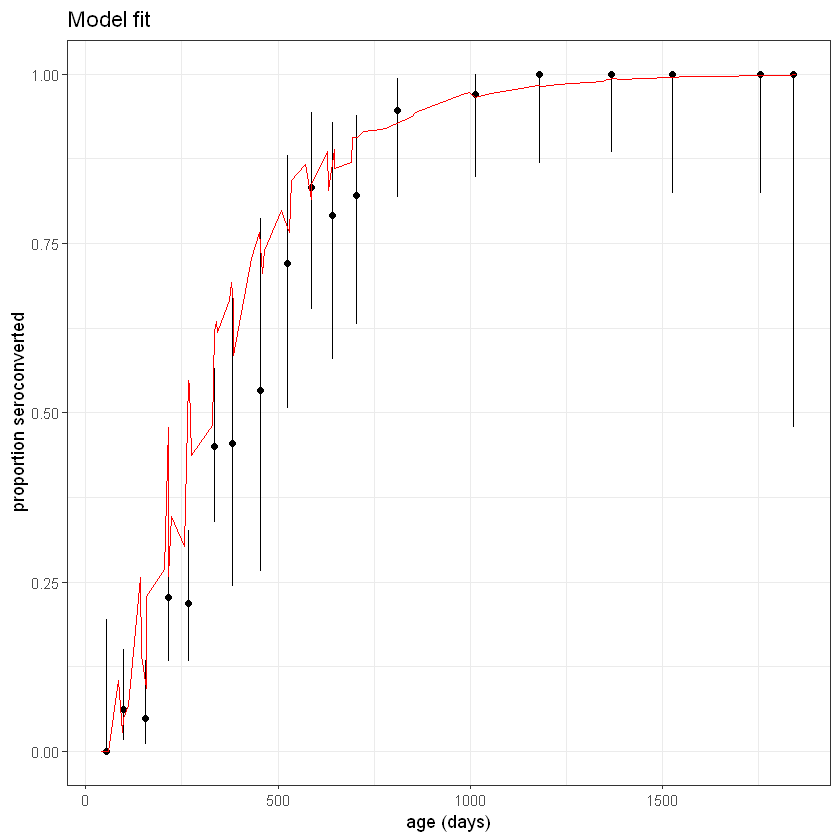

In [81]:
fit <- ggplot() + theme_bw() + ggtitle("Model fit") +
  geom_point(data=data_no_season, aes(x=agemid, y=seroprev_mean)) +
  geom_linerange(data=data_no_season, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  #geom_ribbon(data=trajquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=test_all, aes(x=time, y=conv), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")

fit

In [35]:
seas = 4
# Wrapper for BT: loglik can only take the fitted parameters as argument
# Wrapper for model_all function
loglik_wrapper <- function(par) {
  
  parX = theta
  parX[index] = par
  
  return(loglik2(theta = parX,
                data = data,
                model = match.fun(model_all),
                season = seas,
                inits = inits))
} 

# Wrappers per season
loglik_wrapper_sp <- function(par) {
  
  parX = theta
  parX[index] = par
  
  return(loglik(theta = parX,
                age = agepred_sp, 
                data = spring.df,
                model = match.fun(model_sp),
                inits = inits))
} 

loglik_wrapper_sm <- function(par) {
  
  parX = theta
  parX[index] = par
  
  return(loglik(theta = parX,
                age = agepred_sm, 
                data = summer.df,
                model = match.fun(model_sm),
                inits = inits))
}

loglik_wrapper_au <- function(par) {
  
  parX = theta
  parX[index] = par
  
  return(loglik(theta = parX,
                age = agepred_au, 
                data = autumn.df,
                model = match.fun(model_au),
                inits = inits))
}

loglik_wrapper_wt <- function(par) {
  
  parX = theta
  parX[index] = par
  
  return(loglik(theta = parX,
                age = agepred_wt, 
                data = winter.df,
                model = match.fun(model_wt),
                inits = inits))
}

In [ ]:
# FITTING -------------------------------------------

# Estimated params
estpars <- c("P", "M", "A", "W", "B") # parameters to estimate, can be modified
index <- which(names(theta) %in% estpars) # index of estimated params


# Priors
lower = c(P=0, M=0, A=0, W=0, B = 0)
upper = c(P=0.1, M=0.1, A=0.1, W=0.1, B = 0.2)

prior <- createUniformPrior(lower=lower[estpars], 
                            upper=upper[estpars])
# MCMC settings
nchains <- 2
cpus <- 2 # or 2 if you want parallel, but it does not seem to be faster?
mcmc_settings <- list(iterations = 2*80000, 
                      nrChains = nchains)
sampler <- "Metropolis"

bayesianSetup <- createBayesianSetup(prior = prior,
                                        likelihood = loglik_wrapper,
                                        names = names(theta[index]),
                                        parallel = FALSE)

system.time({trace <- runMCMC(bayesianSetup = bayesianSetup, 
                                 sampler = sampler, 
                                 settings = mcmc_settings)})

'#if (cpus == 1) {
  #spring
  bayesianSetup_sp <- createBayesianSetup(prior = prior,
                                       likelihood = loglik_wrapper_sp,
                                       names = names(theta[index]),
                                       parallel = FALSE)
  
  system.time({trace_sp <- runMCMC(bayesianSetup = bayesianSetup_sp, 
                                sampler = sampler, 
                                settings = mcmc_settings)})
  
  #summer
  bayesianSetup_sm <- createBayesianSetup(prior = prior,
                                          likelihood = loglik_wrapper_sm,
                                          names = names(theta[index]),
                                          parallel = FALSE)
  
  system.time({trace_sm <- runMCMC(bayesianSetup = bayesianSetup_sm, 
                                   sampler = sampler, 
                                   settings = mcmc_settings)})
  
  #autumn
  bayesianSetup_au <- createBayesianSetup(prior = prior,
                                          likelihood = loglik_wrapper_au,
                                          names = names(theta[index]),
                                          parallel = FALSE)
  
  system.time({trace_au <- runMCMC(bayesianSetup = bayesianSetup_au, 
                                   sampler = sampler, 
                                   settings = mcmc_settings)})
  
  # winter
  bayesianSetup_wt <- createBayesianSetup(prior = prior,
                                          likelihood = loglik_wrapper_wt,
                                          names = names(theta[index]),
                                          parallel = FALSE)
  
  system.time({trace_wt <- runMCMC(bayesianSetup = bayesianSetup_wt, 
                                   sampler = sampler, 
                                   settings = mcmc_settings)})
  
}#'

In [ ]:

# DIAGNOSTICS -----------------------------------------------
plot(trace)

'#
plot(trace_sp)
plot(trace_sm) 
plot(trace_au)
plot(trace_wt) 
#'

In [ ]:
# burn-in
nburn <- 10000
plot(trace, parametersOnly = TRUE, start=nburn)
'#
plot(trace_sp, parametersOnly = TRUE, start=nburn)
plot(trace_sm, parametersOnly = TRUE, start=nburn)
plot(trace_au, parametersOnly = TRUE, start=nburn)
plot(trace_wt, parametersOnly = TRUE, start=nburn)#'

# check convergence and correlations
gelmanDiagnostics(trace, plot=TRUE, start=nburn)
'#
gelmanDiagnostics(trace_sp, plot=TRUE, start=nburn)
gelmanDiagnostics(trace_sm, plot=TRUE, start=nburn)
gelmanDiagnostics(trace_au, plot=TRUE, start=nburn)
gelmanDiagnostics(trace_wt, plot=TRUE, start=nburn)#'

correlationPlot(getSample(trace, parametersOnly = TRUE, coda=TRUE, start=nburn), density="smooth", thin=50)
marginalPlot(trace, prior=T, singlePanel=T, start=nburn, nDrawsPrior = 1000)

# remove burn-in for trajsim simulation
tracefinal <- getSample(trace, parametersOnly = TRUE, coda=TRUE, start=nburn)
plot(tracefinal)
effectiveSize(tracefinal)

'#
tracefinal_sp <- getSample(trace_sp, parametersOnly = TRUE, coda=TRUE, start=nburn)
plot(tracefinal_sp)
effectiveSize(tracefinal_sp)

tracefinal_sm <- getSample(trace_sm, parametersOnly = TRUE, coda=TRUE, start=nburn)
plot(tracefinal_sm)
effectiveSize(tracefinal_sm)

tracefinal_au <- getSample(trace_au, parametersOnly = TRUE, coda=TRUE, start=nburn)
plot(tracefinal_au)
effectiveSize(tracefinal_au)

tracefinal_wt <- getSample(trace_wt, parametersOnly = TRUE, coda=TRUE, start=nburn)
plot(tracefinal_wt)
effectiveSize(tracefinal_wt)#'

# Posterior summary
summary(tracefinal)

'#
summary(tracefinal_sp)
summary(tracefinal_sm)
summary(tracefinal_wt)
summary(tracefinal_au)#'

# save the trace
#saveRDS(trace_sp, "trace_FOI_w_all_season_together_prop.rds")


# POSTPROCESSING AND RESULTS -----------------------------------

# Calculate simulated trajectory quantiles
trajsim <- maketrajsim2(tracefinal, theta, agepred, model_all, data, inits, 1000, seas) 
trajquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"conv"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(trajquantiles) <- c("agemid", "low95", "median", "up95")

lambda_quantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"lambda"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_quantiles) <- c("agemid", "low95", "median", "up95")

wquantiles <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"mu"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(wquantiles) <- c("agemid", "low95", "median", "up95")


'#
#Spring
trajsim_sp <- maketrajsim(tracefinal_sp, theta, agepred_sp, model_sp, inits, 1000)
trajquantiles_sp <- plyr::ddply(.data=trajsim, .variables="time", function(x) quantile(x[,"conv"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(trajquantiles_sp) <- c("agemid", "low95", "median", "up95")

lambda_spquantiles <- plyr::ddply(.data=trajsim_sp, .variables="time", function(x) quantile(x[,"lambda"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_spquantiles) <- c("agemid", "low95", "median", "up95")

wquantiles_sp <- plyr::ddply(.data=trajsim_sp, .variables="time", function(x) quantile(x[,"mu"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(wquantiles_sp) <- c("agemid", "low95", "median", "up95")

#Summer
trajsim_sm <- maketrajsim(tracefinal_sm, theta, agepred_sm, model_sm, inits, 1000)
trajquantiles_sm <- plyr::ddply(.data=trajsim_sm, .variables="time", function(x) quantile(x[,"conv"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(trajquantiles_sm) <- c("agemid", "low95", "median", "up95")

lambda_smquantiles <- plyr::ddply(.data=trajsim_sm, .variables="time", function(x) quantile(x[,"lambda"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_smquantiles) <- c("agemid", "low95", "median", "up95")
wquantiles_sm <- plyr::ddply(.data=trajsim_sm, .variables="time", function(x) quantile(x[,"mu"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(wquantiles_sm) <- c("agemid", "low95", "median", "up95")

#Autumn
trajsim_au <- maketrajsim(tracefinal_au, theta, agepred_au, model_au, inits, 1000)
trajquantiles_au <- plyr::ddply(.data=trajsim_au, .variables="time", function(x) quantile(x[,"conv"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(trajquantiles_au) <- c("agemid", "low95", "median", "up95")

lambda_auquantiles <- plyr::ddply(.data=trajsim_au, .variables="time", function(x) quantile(x[,"lambda"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_auquantiles) <- c("agemid", "low95", "median", "up95")

wquantiles_au <- plyr::ddply(.data=trajsim_au, .variables="time", function(x) quantile(x[,"mu"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(wquantiles_au) <- c("agemid", "low95", "median", "up95")

#Winter
trajsim_wt <- maketrajsim(tracefinal_wt, theta, agepred_wt, model_wt, inits, 1000)
trajquantiles_wt <- plyr::ddply(.data=trajsim_wt, .variables="time", function(x) quantile(x[,"conv"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(trajquantiles_wt) <- c("agemid", "low95", "median", "up95")

lambda_wtquantiles <- plyr::ddply(.data=trajsim_wt, .variables="time", function(x) quantile(x[,"lambda"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(lambda_wtquantiles) <- c("agemid", "low95", "median", "up95")

wquantiles_wt <- plyr::ddply(.data=trajsim_wt, .variables="time", function(x) quantile(x[,"mu"], prob = c(0.025, 0.5, 0.975), na.rm=T)) 
colnames(wquantiles_wt) <- c("agemid", "low95", "median", "up95")
#'



# Plot fit and FOI
fit <- ggplot() + theme_bw() + ggtitle("Model fit") +
  geom_point(data=summer.df, aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_linerange(data=summer.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")

fit

fit_no_season <- ggplot() + theme_bw() + ggtitle("Model fit") +
  geom_point(data=data, aes(x=agemid, y=seroprev_mean, colour = season_birth)) +
  geom_linerange(data=data, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") + labs(colour = "season of birth")
fit_no_season


lambda <- ggplot() + theme_bw() + ggtitle("FOI over time") +
  geom_ribbon(data=lambda_quantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_quantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda

w <- ggplot() + theme_bw() + ggtitle("Waning maternal immunity") +
  geom_ribbon(data=wquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=wquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("Maternal immunity") 
w

'#
fit_sp <- ggplot() + theme_bw() + ggtitle("model fit in spring") +
  geom_point(data=spring.df, aes(x=agemid, y=seroprev_mean)) +
  geom_linerange(data=spring.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") 


fit_sp

lambda_sp <- ggplot() + theme_bw() + ggtitle("FOI in spring") +
  geom_ribbon(data=lambda_spquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_spquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_sp

fit_sm <- ggplot() + theme_bw() + ggtitle("model fit in summer") +
  geom_point(data=summer.df, aes(x=agemid, y=seroprev_mean)) +
  geom_linerange(data=summer.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles_sm, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles_sm, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") 


fit_sm

lambda_sm <- ggplot() + theme_bw() + ggtitle("FOI in summer") +
  geom_ribbon(data=lambda_smquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_smquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_sm

fit_au <- ggplot() + theme_bw() + ggtitle("model fit in autumn") +
  geom_point(data=autumn.df, aes(x=agemid, y=seroprev_mean)) +
  geom_linerange(data=autumn.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles_au, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles_au, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") 


fit_au

lambda_au <- ggplot() + theme_bw() + ggtitle("FOI in autumn") +
  geom_ribbon(data=lambda_auquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_auquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_au

w_au <- ggplot() + theme_bw() + ggtitle("Waning maternal immunity in autumn") +
  geom_ribbon(data=wquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=wquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("Maternal immunity") 


w_au


fit_wt <- ggplot() + theme_bw() + ggtitle("model fit in winter") +
  geom_point(data=winter.df, aes(x=agemid, y=seroprev_mean)) +
  geom_linerange(data=winter.df, aes(x=agemid, ymin=seroprev_low95, ymax=seroprev_up95)) +
  geom_ribbon(data=trajquantiles_wt, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=trajquantiles_wt, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("proportion seroconverted") 


fit_wt


lambda_wt <- ggplot() + theme_bw() + ggtitle("FOI in winter") +
  geom_ribbon(data=lambda_wtquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=lambda_wtquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("FOI") 
lambda_wt

w_wt <- ggplot() + theme_bw() + ggtitle("Waning maternal immunity in winter") +
  geom_ribbon(data=wquantiles, aes(x=agemid, ymin=low95, ymax=up95), fill="red", alpha=0.3) +
  geom_line(data=wquantiles, aes(x=agemid, y=median), color="red") +
  xlab("age (days)") + ylab("Maternal immunity") 


w_wt
#'



